In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import joblib

In [2]:
class PlaceDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_to_idx = {}
        
        # Собираем все изображения и создаем маппинг меток
        current_idx = 0
        for label in os.listdir(self.dataset_path):
            label_path = os.path.join(self.dataset_path, label)
            if not os.path.isdir(label_path):
                continue
                
            if label not in self.label_to_idx:
                self.label_to_idx[label] = current_idx
                current_idx += 1
                
            for img_name in os.listdir(label_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(label_path, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(self.label_to_idx[label])
        
        self.num_classes = len(self.label_to_idx)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            return img, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Возвращаем пустое изображение в случае ошибки
            dummy_img = torch.zeros(3, 224, 224) if self.transform else Image.new('RGB', (224, 224))
            return dummy_img, label

In [3]:
class PlaceRecognizer:
    def __init__(self, dataset_path='dataset'):
        self.dataset_path = dataset_path
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Трансформации для обучения
        self.train_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        # Трансформации для валидации/теста
        self.val_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        

        self.model = models.resnet50(pretrained=True)

        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, len(os.listdir(dataset_path)))
        self.model = self.model.to(self.device)
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)
        
        self.features_model = nn.Sequential(*list(self.model.children())[:-1])
        self.features = []
        self.image_paths = []
        self.labels = []
        self.label_names = []
    
    def train(self, num_epochs=10, batch_size=32):
        """Обучение модели"""
        train_dataset = PlaceDataset(self.dataset_path, self.train_transform)
        
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=0,
            pin_memory=True
        )
        
        print(f"Начинаем обучение на {len(train_dataset)} изображениях...")
        print(f"Количество классов: {train_dataset.num_classes}")
        
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                self.optimizer.zero_grad()
                
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = 100 * correct / total
            print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    
    def extract_features(self):
        """Извлечение признаков после обучения"""
        val_dataset = PlaceDataset(self.dataset_path, self.val_transform)
        val_loader = DataLoader(
            val_dataset, 
            batch_size=32, 
            shuffle=False, 
            num_workers=0,
            pin_memory=True
        )
        
        self.features_model.eval()
        self.features = []
        self.image_paths = val_dataset.image_paths
        self.labels = val_dataset.labels
        self.label_names = list(val_dataset.label_to_idx.keys())
        
        with torch.no_grad():
            for inputs, _ in tqdm(val_loader, desc="Извлечение признаков"):
                inputs = inputs.to(self.device)
                features = self.features_model(inputs)
                self.features.append(features.cpu().numpy())
        
        self.features = np.vstack(self.features)
        self.features = self.features.reshape(self.features.shape[0], -1)
        
        # Обучаем nearest neighbors для поиска похожих изображений
        self.nn = NearestNeighbors(n_neighbors=3, metric='cosine')
        self.nn.fit(self.features)
    
    def recognize_place(self, query_img_path):
        """Распознавание места и поиск похожих изображений"""
        try:
            # Загружаем и преобразуем изображение
            img = Image.open(query_img_path).convert('RGB')
            img_tensor = self.val_transform(img).unsqueeze(0).to(self.device)
            
            # Извлекаем признаки
            with torch.no_grad():
                self.features_model.eval()
                query_features = self.features_model(img_tensor)
                query_features = query_features.cpu().numpy().flatten()
            
            # Поиск ближайших соседей
            distances, indices = self.nn.kneighbors([query_features])
            
            # Получение результатов
            label_idx = self.labels[indices[0][0]]
            predicted_label = self.label_names[label_idx]
            similar_images = [self.image_paths[i] for i in indices[0]]
            similar_distances = distances[0]
            
            return predicted_label, list(zip(similar_images, similar_distances))
        except Exception as e:
            print(f"Ошибка при распознавании: {e}")
            return None, []
        
    def save_model(self, save_dir='model'):
        """Сохранение всей модели и данных"""
        os.makedirs(save_dir, exist_ok=True)
        
        # Сохраняем PyTorch модель
        torch.save({
            'model_state': self.model.state_dict(),
            'optimizer_state': self.optimizer.state_dict(),
        }, os.path.join(save_dir, 'model_weights.pth'))
        
        # Сохраняем остальные данные с помощью joblib
        data_to_save = {
            'features': self.features,
            'image_paths': self.image_paths,
            'labels': self.labels,
            'label_names': self.label_names,
            'nn': self.nn
        }
        joblib.dump(data_to_save, os.path.join(save_dir, 'recognizer_data.joblib'))
        
        print(f"Модель сохранена в папке {save_dir}")


    def initialize_model(self):
        """Инициализация или переинициализация модели"""
        # Загружаем предобученную ResNet50
        self.model = models.resnet50(pretrained=True)
        
        # Заменяем последний слой для нашего числа классов
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, len(os.listdir(self.dataset_path)))
        self.model = self.model.to(self.device)
        
        # Инициализируем оптимизатор и критерий
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)
        
        # Модель для извлечения признаков (без последнего слоя)
        self.features_model = nn.Sequential(*list(self.model.children())[:-1])
        
        # Инициализируем структуры для хранения данных
        self.features = []
        self.image_paths = []
        self.labels = []
        self.label_names = []
        self.nn = None
    
    
    def load_model(self, save_dir='model'):
        """Загрузка модели и данных"""
        # Загружаем веса модели
        checkpoint = torch.load(os.path.join(save_dir, 'model_weights.pth'))
        self.initialize_model()  # Переинициализируем модель
        self.model.load_state_dict(checkpoint['model_state'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state'])
        
        # Загружаем остальные данные
        data_loaded = joblib.load(os.path.join(save_dir, 'recognizer_data.joblib'))
        self.features = data_loaded['features']
        self.image_paths = data_loaded['image_paths']
        self.labels = data_loaded['labels']
        self.label_names = data_loaded['label_names']
        self.nn = data_loaded['nn']
        
        # Переводим модель в eval режим
        self.model.eval()
        self.features_model = nn.Sequential(*list(self.model.children())[:-1]).to(self.device)
        
        print(f"Модель загружена из папки {save_dir}")

In [4]:
recognizer = PlaceRecognizer(dataset_path='dataset')

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
recognizer.train(num_epochs=12)

Начинаем обучение на 1945 изображениях...
Количество классов: 7


Epoch 1/12: 100%|██████████| 61/61 [05:12<00:00,  5.13s/it]


Epoch 1, Loss: 1.2059, Accuracy: 61.70%


Epoch 2/12: 100%|██████████| 61/61 [04:56<00:00,  4.86s/it]


Epoch 2, Loss: 0.4666, Accuracy: 87.10%


Epoch 3/12: 100%|██████████| 61/61 [04:57<00:00,  4.88s/it]


Epoch 3, Loss: 0.2940, Accuracy: 91.67%


Epoch 4/12: 100%|██████████| 61/61 [04:59<00:00,  4.90s/it]


Epoch 4, Loss: 0.2188, Accuracy: 93.32%


Epoch 5/12: 100%|██████████| 61/61 [04:58<00:00,  4.89s/it]


Epoch 5, Loss: 0.1863, Accuracy: 93.26%


Epoch 6/12: 100%|██████████| 61/61 [04:59<00:00,  4.90s/it]


Epoch 6, Loss: 0.1351, Accuracy: 95.94%


Epoch 7/12: 100%|██████████| 61/61 [05:01<00:00,  4.95s/it]


Epoch 7, Loss: 0.1332, Accuracy: 95.89%


Epoch 8/12: 100%|██████████| 61/61 [05:13<00:00,  5.13s/it]


Epoch 8, Loss: 0.1164, Accuracy: 96.81%


Epoch 9/12: 100%|██████████| 61/61 [05:29<00:00,  5.40s/it]


Epoch 9, Loss: 0.1063, Accuracy: 97.02%


Epoch 10/12: 100%|██████████| 61/61 [05:29<00:00,  5.40s/it]


Epoch 10, Loss: 0.0861, Accuracy: 97.33%


Epoch 11/12: 100%|██████████| 61/61 [05:12<00:00,  5.12s/it]


Epoch 11, Loss: 0.0737, Accuracy: 97.89%


Epoch 12/12: 100%|██████████| 61/61 [05:02<00:00,  4.97s/it]

Epoch 12, Loss: 0.0898, Accuracy: 97.48%


In [6]:
recognizer.extract_features()

Извлечение признаков: 100%|██████████| 61/61 [04:55<00:00,  4.85s/it]


In [7]:
recognizer.save_model()

Модель сохранена в папке model


In [15]:
recognizer.load_model()

Модель загружена из папки model


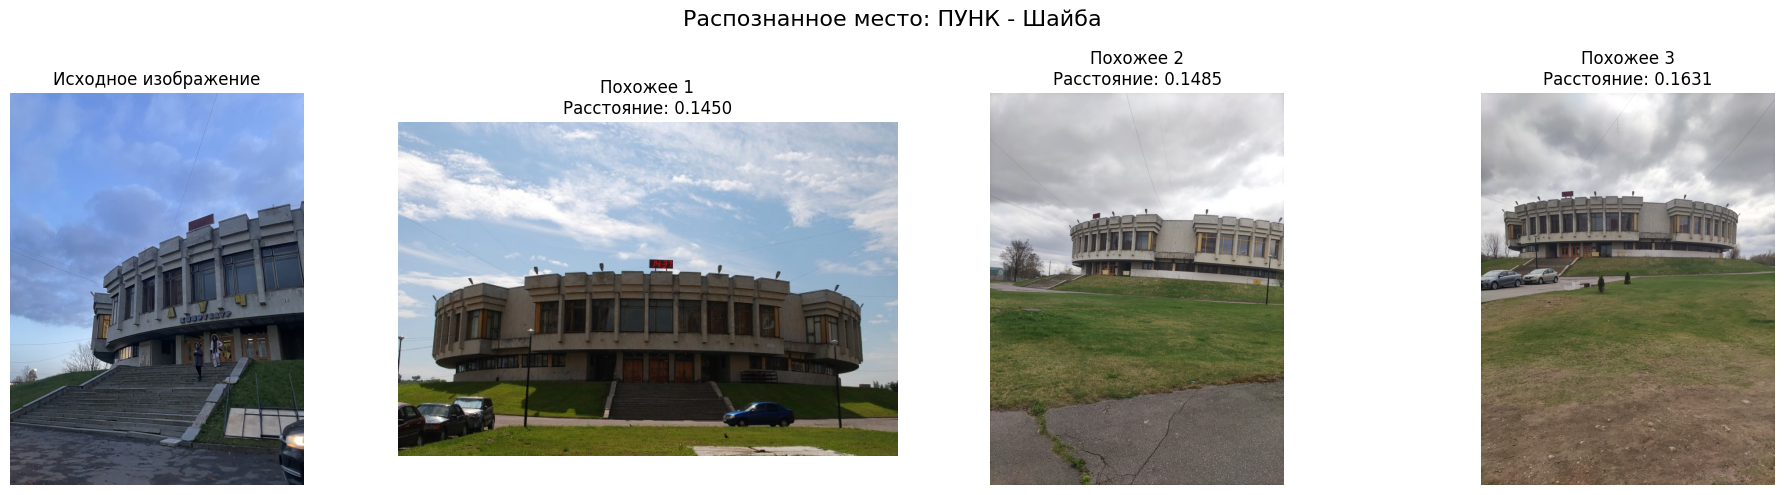

Распознанное место: ПУНК - Шайба
Три наиболее похожих изображения:
1. dataset\ПУНК - Шайба\phoca_thumb_l_dsc_0300.jpg (расстояние: 0.1450)
2. dataset\ПУНК - Шайба\IMG_20250422_145035.jpg (расстояние: 0.1485)
3. dataset\ПУНК - Шайба\IMG_20250422_141829.jpg (расстояние: 0.1631)


In [14]:
query_image = 'test/sh.jpg'
if os.path.exists(query_image):
    label, similar = recognizer.recognize_place(query_image)
    if label:
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        fig.suptitle(f"Распознанное место: {label}", fontsize=16)
            

        axes[0].imshow(imread(query_image))
        axes[0].set_title("Исходное изображение")
        axes[0].axis('off')
            

        for i, (img_path, distance) in enumerate(similar, 1):
            axes[i].imshow(imread(img_path))
            axes[i].set_title(f"Похожее {i}\nРасстояние: {distance:.4f}")
            axes[i].axis('off')
            
        plt.tight_layout()
        plt.show()
            

        print(f"Распознанное место: {label}")
        print("Три наиболее похожих изображения:")
        for i, (img_path, distance) in enumerate(similar, 1):
            print(f"{i}. {img_path} (расстояние: {distance:.4f})")
else:
    print(f"Тестовое изображение {query_image} не найдено")